<a href="https://colab.research.google.com/github/HaeSeon/nlp-ner/blob/main/%5Bbi_lstm%2Bcrf_ner%5Dkeras_jp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 환경 setting

In [1]:
!pip install tensorflow==1.14.0
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
# crf 사용을 위해 keras_contrib을 설치
!pip install git+https://www.github.com/keras-team/keras-contrib.git

     |████████████████████████████████| 109.3MB 37kB/s 
     |████████████████████████████████| 491kB 40.8MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 3.2MB 43.3MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 317kB 25.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 377.1MB 32kB/s 
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-lqb2ae3v
  Running command git clone -q 

# 데이터 전처리

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
train_set = 'train_set.txt'
test_set = 'test_set.txt'
f = open(train_set)
f.readlines()[:10]

['1960\tB-DATE\n',
 '年代\tI-DATE\n',
 'と\tO\n',
 '1970\tB-DATE\n',
 '年代\tI-DATE\n',
 'の\tO\n',
 '間\tO\n',
 'に\tO\n',
 '、\tO\n',
 'ジョエル\tB-PERSON\n']

In [4]:
def process_data(file_name):
  sentence=[]
  taged_sentences=[]
  with open (file_name,'r') as f:
    for line in f.readlines():
      if "。" in line and len(sentence)>0:
        taged_sentences.append(sentence)
        sentence=[]
      else:
        if(len(line.split('\t'))>1):
          word=line.split('\t')[0]
          tag=line.split('\t')[1]
          sentence.append((word, tag))

  return taged_sentences

In [5]:
train_sents=process_data(train_set)
test_sents=process_data(test_set)

In [6]:
train_sents[0]

[('1960', 'B-DATE\n'),
 ('年代', 'I-DATE\n'),
 ('と', 'O\n'),
 ('1970', 'B-DATE\n'),
 ('年代', 'I-DATE\n'),
 ('の', 'O\n'),
 ('間', 'O\n'),
 ('に', 'O\n'),
 ('、', 'O\n'),
 ('ジョエル', 'B-PERSON\n'),
 ('・', 'I-PERSON\n'),
 ('モーゼス', 'I-PERSON\n'),
 ('は', 'O\n'),
 (' ', 'O\n'),
 ('プログラム', 'O\n'),
 ('中', 'O\n'),
 ('で', 'O\n'),
 ('積分', 'O\n'),
 ('問題', 'O\n'),
 ('で', 'O\n'),
 ('の', 'O\n'),
 ('記号', 'O\n'),
 ('的', 'O\n'),
 ('推論', 'O\n'),
 ('の', 'O\n'),
 ('パワー', 'O\n'),
 ('を', 'O\n'),
 ('示し', 'O\n'),
 ('た', 'O\n')]

In [7]:
# sentence, ner_tag 분리
def separate_sentence_tag(tagged_sentences):
  sentences, ner_tags = [], [] 
  for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.
  return sentences, ner_tags

In [8]:
train_sentences, train_tags = separate_sentence_tag(train_sents)
test_sentences,test_tags = separate_sentence_tag(test_sents)

In [9]:
def deleteSpace(tags):
  new_tags=[]
  for tag in tags:
    tag=[word.strip("\n") for word in tag]
    new_tags.append(tag)
  return new_tags

In [10]:
train_tags=deleteSpace(train_tags)
test_tags=deleteSpace(test_tags)

In [11]:
print(train_sentences[0]) #예측을 위한 X
print(train_tags[0])  #예측 대상인 Y

['1960', '年代', 'と', '1970', '年代', 'の', '間', 'に', '、', 'ジョエル', '・', 'モーゼス', 'は', ' ', 'プログラム', '中', 'で', '積分', '問題', 'で', 'の', '記号', '的', '推論', 'の', 'パワー', 'を', '示し', 'た']
['B-DATE', 'I-DATE', 'O', 'B-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-PERSON', 'I-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**train data**

샘플의 최대 길이 : 191
샘플의 평균 길이 : 34.853636


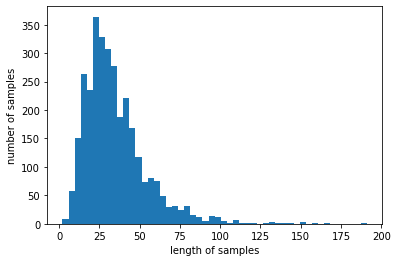

In [12]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in train_sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, train_sentences))/len(train_sentences)))
plt.hist([len(s) for s in train_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**test data**

샘플의 최대 길이 : 190
샘플의 평균 길이 : 34.840050


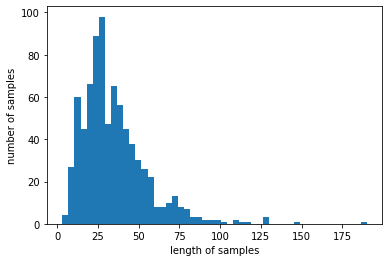

In [13]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in test_sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, test_sentences))/len(test_sentences)))
plt.hist([len(s) for s in test_sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

**케라스 토크나이저를 통해 정수인코딩**

In [14]:
# 문장 데이터에 대해서는 src_tokenizer
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(train_sentences+test_sentences)
# 개체명 태깅 정보에 대해서는 tar_tokenizer
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(train_tags+test_tags)

In [15]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 15962
개체명 태깅 정보 집합의 크기 : 24


In [16]:
# 앞서 src_tokenizer를 만들때 Tokenizer의 인자로 oov_token='OOV'를 선택했으므로 인덱스 1에 'OOV' 할당
print('단어 OOV의 인덱스 : {}'.format(src_tokenizer.word_index['OOV']))

단어 OOV의 인덱스 : 1


In [17]:
# 정수 인코딩
X_train = src_tokenizer.texts_to_sequences(train_sentences)
y_train = tar_tokenizer.texts_to_sequences(train_tags)
X_test = src_tokenizer.texts_to_sequences(test_sentences)
y_test = tar_tokenizer.texts_to_sequences(test_tags)
print(X_train[0])  #문장 데이터의 정수 인코딩 결과
print(y_train[0])  #개체명 태깅 데이터에 대해서 정수 인코딩의 결과

[864, 104, 11, 653, 104, 2, 128, 4, 3, 7949, 22, 7950, 5, 27, 722, 66, 9, 7951, 157, 9, 2, 3962, 29, 2603, 2, 1932, 6, 723, 8]
[6, 3, 1, 6, 3, 1, 1, 1, 1, 9, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
# 모델 훈련 후 결과 확인을 위해 인덱스로부터 단어를 리턴하는 배열 만들어두기
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'
print(index_to_ner)

{1: 'O', 2: 'B-LOCATION', 3: 'I-DATE', 4: 'I-ORGANIZATION', 5: 'B-ORGANIZATION', 6: 'B-DATE', 7: 'I-NUMBER', 8: 'I-ARTIFACT', 9: 'B-PERSON', 10: 'I-LOCATION', 11: 'B-NUMBER', 12: 'I-PERSON', 13: 'B-ARTIFACT', 14: 'I-EVENT', 15: 'I-OTHER', 16: 'B-OTHER', 17: 'I-PERCENT', 18: 'B-EVENT', 19: 'B-PERCENT', 20: 'I-MONEY', 21: 'B-MONEY', 22: 'I-TIME', 23: 'B-TIME', 0: 'PAD'}


In [19]:
max_len = 200
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
y_test = pad_sequences(y_test, padding='post', maxlen=max_len)

In [20]:
# 레이블에 대해 one hot 인코딩
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [21]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3177, 200)
훈련 샘플 레이블의 크기 : (3177, 200, 24)
테스트 샘플 문장의 크기 : (794, 200)
테스트 샘플 레이블의 크기 : (794, 200, 24)


# F1-score를 측정하는 콜백 클래스


In [22]:
!pip install seqeval

     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=f87d2169c830bd8e3b6866d75fea2e3a393869e0ef7668a266a131b672340b37
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [23]:
from keras.callbacks import Callback
from seqeval.metrics import f1_score, classification_report

Using TensorFlow backend.


In [24]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
      result = []
      for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
          tag = []
          for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
              pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
          result.append(tag)
      return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):

      # char Embedding을 사용하는 경우
      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      # F1-score가 지금까지 중 가장 높은 경우
      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

# Bi LSTM+CRF를 이용한 개체명 인식(NER)

In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

모델에 양방향 LSTM을 사용하고 모델의 출력층에 CRF층을 배치한다. 

In [26]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation="relu")))
crf = CRF(tag_size)
model.add(crf)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [27]:
# Loss graph
import matplotlib.pyplot as plt

In [28]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
history = model.fit(X_train, y_train, batch_size = 32, epochs = 50, validation_split = 0.1, verbose = 1, callbacks=[F1score(use_char=False)])

 

/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '



Train on 2859 samples, validate on 318 samples
Epoch 1/50
2859/2859 [==============================] - 93s 32ms/step - loss: 22.5725 - crf_viterbi_accuracy: 0.7787 - val_loss: 22.3057 - val_crf_viterbi_accuracy: 0.8642
 - f1: 0.00


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    ARTIFACT       0.00      0.00      0.00        71
        DATE       0.00      0.00      0.00        97
       EVENT       0.00      0.00      0.00        24
    LOCATION       0.00      0.00      0.00       186
       MONEY       0.00      0.00      0.00         2
      NUMBER       0.00      0.00      0.00        76
ORGANIZATION       0.00      0.00      0.00       126
       OTHER       0.00      0.00      0.00        19
     PERCENT       0.00      0.00      0.00         6
      PERSON       0.00      0.00      0.00       116
        TIME       0.00      0.00      0.00         3

   micro avg       0.00      0.00      0.00       726
   macro avg       0.00      0.00      0.00       726
weighted avg       0.00      0.00      0.00       726

f1_score did not improve from 0.000000
Epoch 2/50
2859/2859 [==============================] - 88s 31ms/step - loss: 21.9519 - crf_viterbi_accuracy: 0.8538 - val_loss: 22.0927 - val_crf_v

**accyracy와 ecpoch 그래프**



dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])


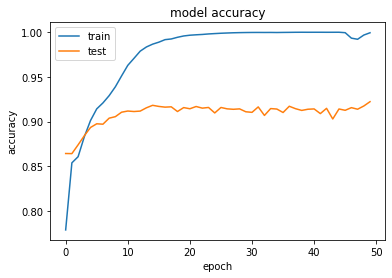

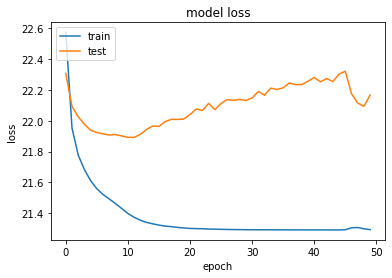

In [35]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
bilstm_crf_model = load_model('best_model.h5', custom_objects={'CRF':CRF,
                                                  'crf_loss':crf_loss,
                                                  'crf_viterbi_accuracy':crf_viterbi_accuracy})

In [37]:
i=13 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_predicted = bilstm_crf_model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))

단어             |실제값  |예측값
-----------------------------------
トーナメント           : O       O
など               : O       O
で                : O       O
引き分け             : O       O
と                : O       O
なっ               : O       O
た                : O       O
場合               : O       O
は                : O       O
、                : O       O
引き分け             : O       O
を                : O       O
つけ               : O       O
た                : O       O
ジャッジ             : O       O
が                : O       O
最終               : O       O
判断               : O       O
を                : O       O
下し               : O       O
て                : O       O
決着               : O       O
を                : O       O
付ける              : O       O
こと               : O       O
に                : O       O
なる               : O       O
が                : O       O
、                : O       O
大会               : O       O
によって             : O       O
は                : O       O
延長        

# F1 score 구하기

앞서 구현한 모델에 대해서 f1-score를 적용하자. 모델의 return값이 숫자로 구성되어있기때문에 이를 먼저 태깅이 나열되어있는 리스트로 치환을 해야한다. 이 작업을 위해서 sequence_to_tag함수를 사용한다.

In [38]:
f1score = F1score(use_char=False)

y_predicted = bilstm_crf_model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)

In [39]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

    ARTIFACT       0.29      0.18      0.22       170
        DATE       0.92      0.82      0.87       306
       EVENT       0.33      0.37      0.35        41
    LOCATION       0.49      0.54      0.51       598
       MONEY       0.38      0.43      0.41        23
      NUMBER       0.63      0.61      0.62       213
ORGANIZATION       0.47      0.38      0.42       348
       OTHER       0.36      0.50      0.42        84
     PERCENT       0.59      0.54      0.56        41
      PERSON       0.38      0.15      0.21       300
        TIME       0.20      0.20      0.20         5

   micro avg       0.53      0.47      0.50      2129
   macro avg       0.46      0.43      0.44      2129
weighted avg       0.52      0.47      0.49      2129



In [40]:
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))

F1-score: 50.0%
